In [1]:
import os
import librosa   #thư viện xủ lý tín hiệu âm thanh
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #để đọc file wav 
import warnings
import tensorflow as tf
warnings.filterwarnings("ignore")
from keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler

c:\users\phuong\appdata\local\programs\python\python37\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
c:\users\phuong\appdata\local\programs\python\python37\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
import librosa.display

from numpy import load
from numpy import save
from numpy import asarray
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'noise']
all_wave = load('all_wave.npy')
# 
all_label = load('all_label.npy')

#     all_feature.append(feature_vector_2)

In [3]:
#generate features
all_feature=[]
for word in all_wave:
    norm = np.mean(abs(word))*250
    normal_word = word/norm
    feature_vector_1 = librosa.feature.chroma_stft(y=normal_word, sr=16000)
    feature_vector_2 = librosa.feature.melspectrogram(y=normal_word, sr=16000)[:40]
    feature_vector = np.concatenate((feature_vector_1,feature_vector_2))
    all_feature.append(feature_vector)

In [43]:
norm

0.009167971

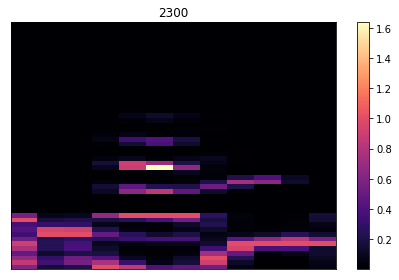

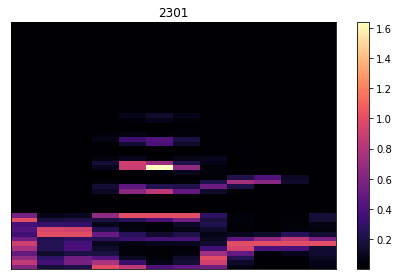

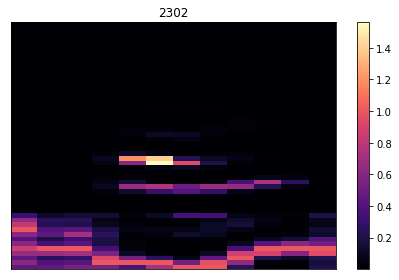

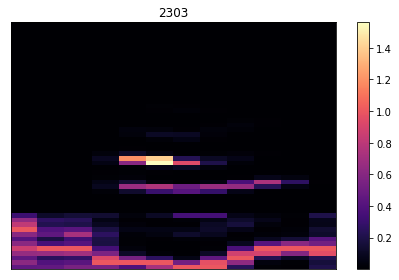

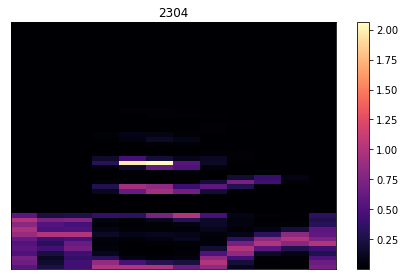

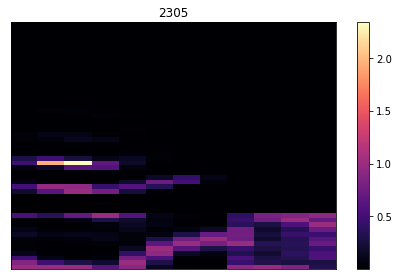

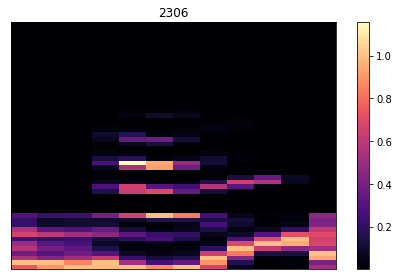

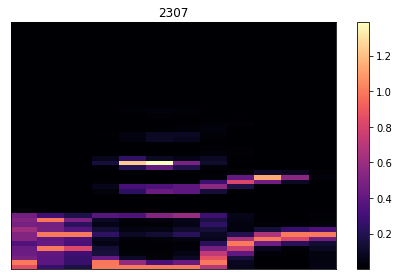

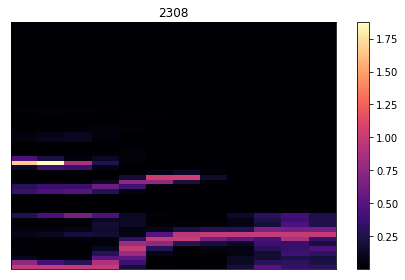

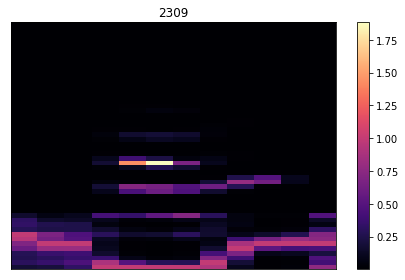

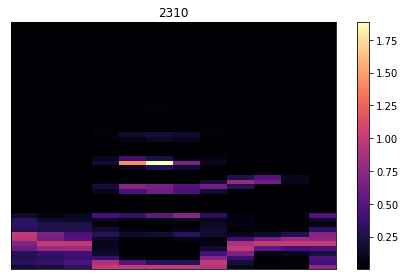

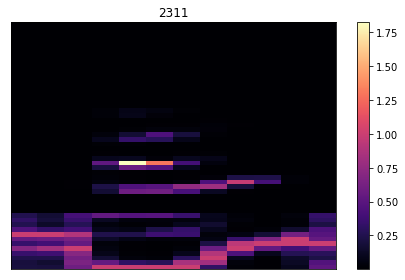

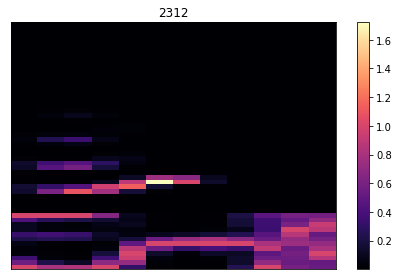

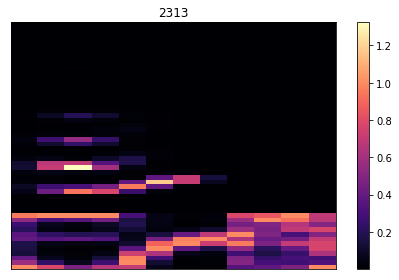

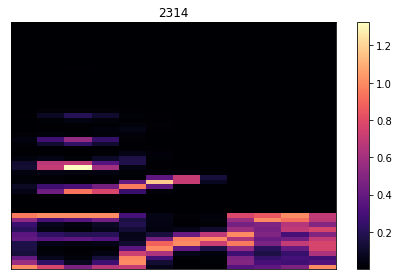

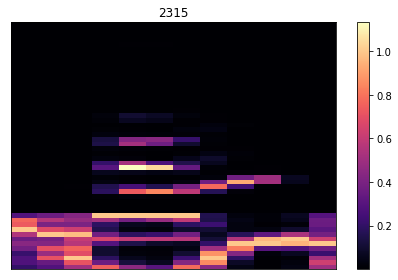

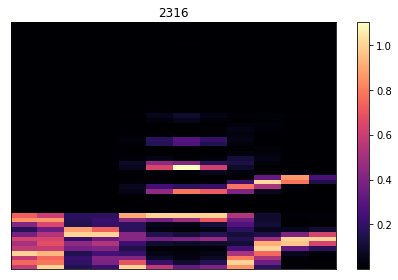

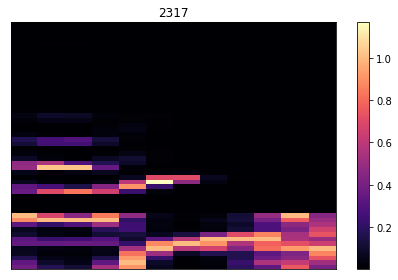

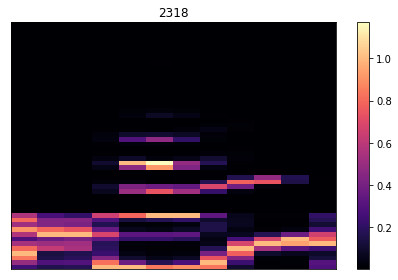

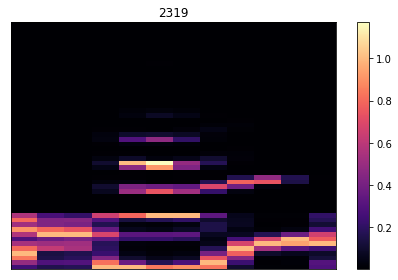

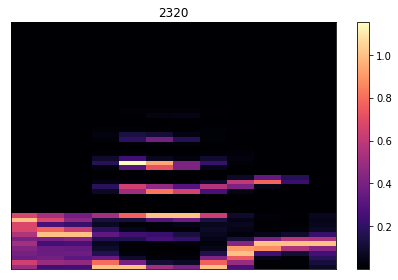

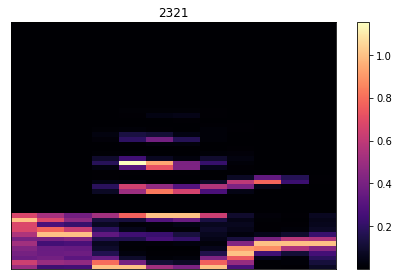

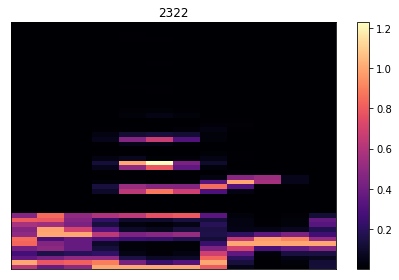

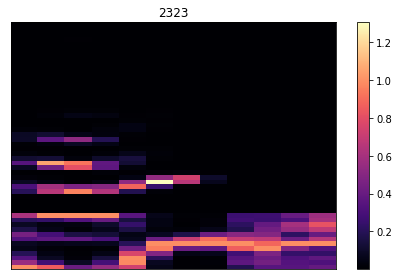

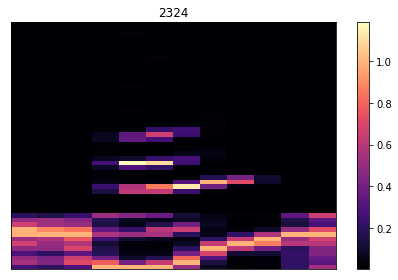

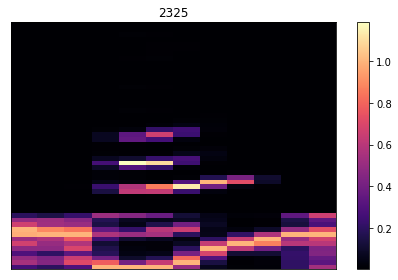

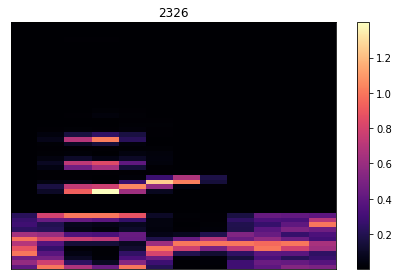

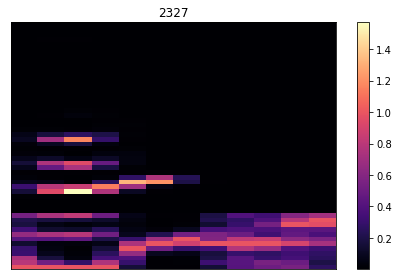

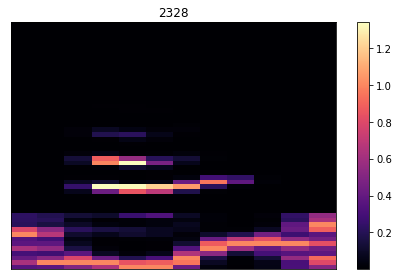

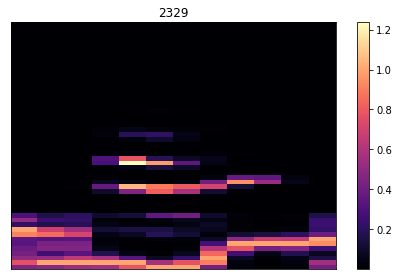

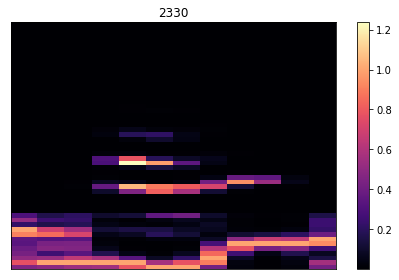

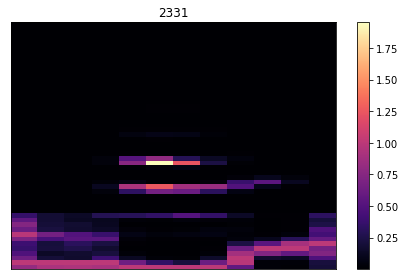

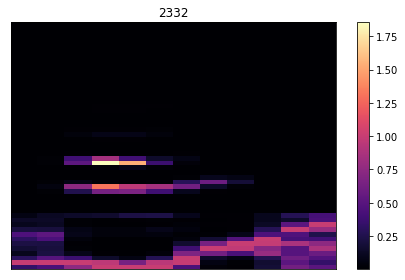

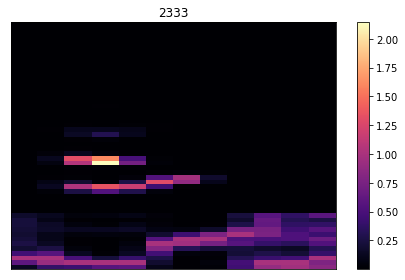

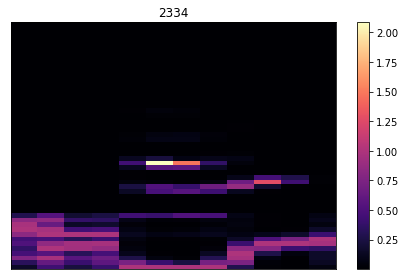

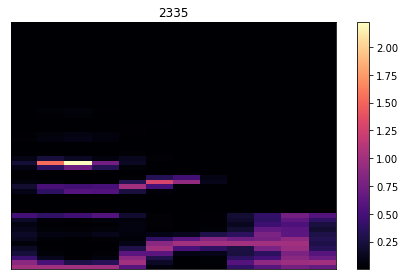

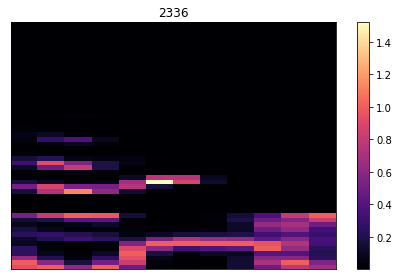

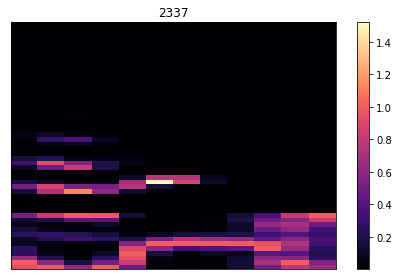

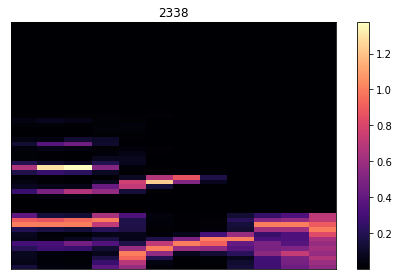

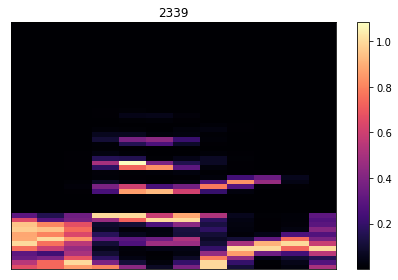

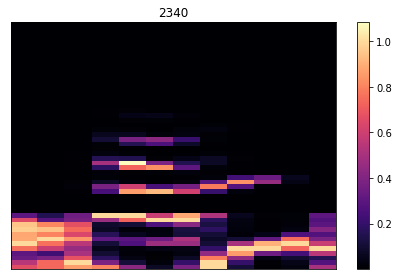

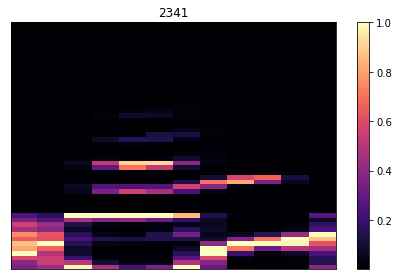

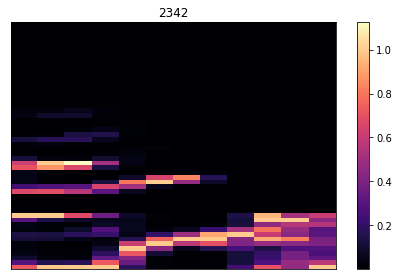

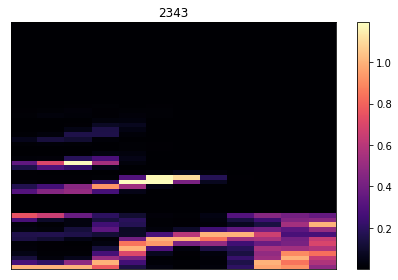

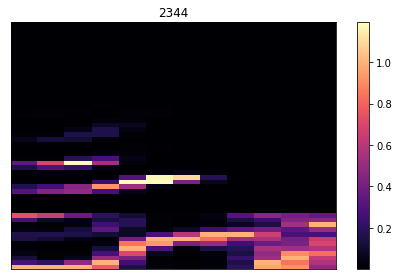

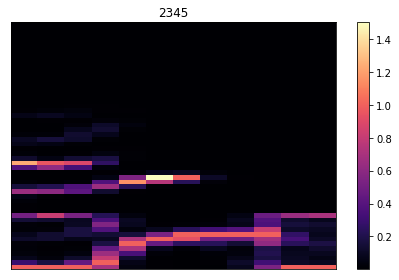

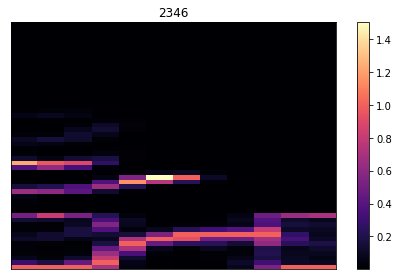

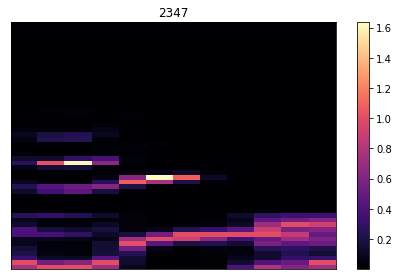

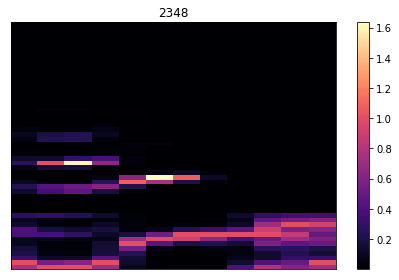

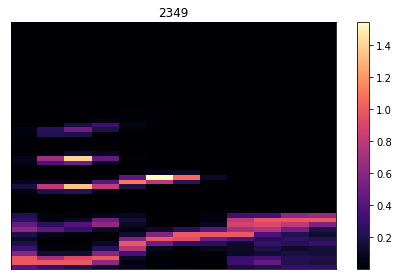

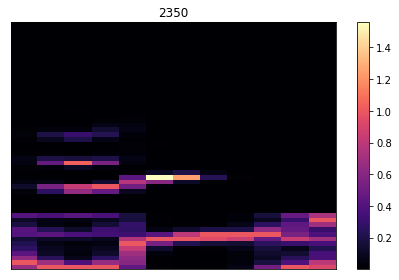

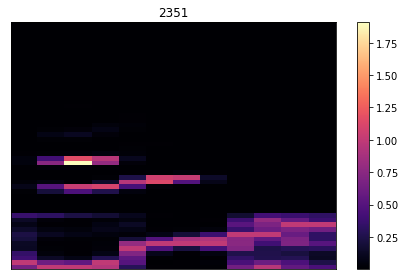

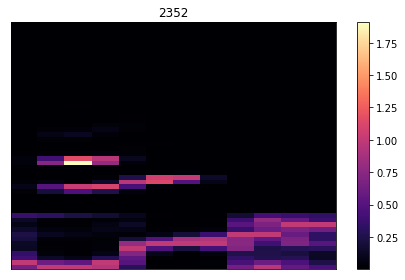

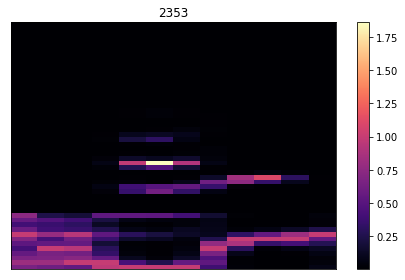

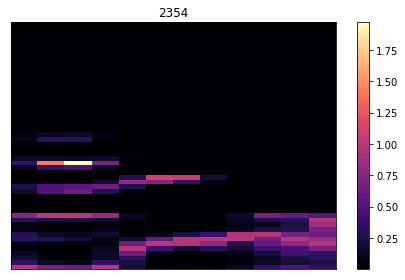

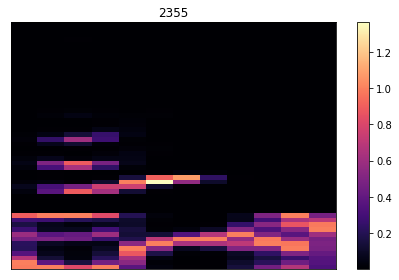

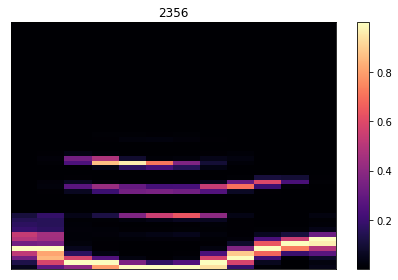

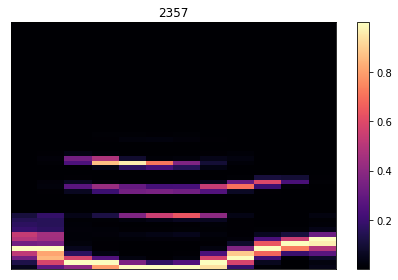

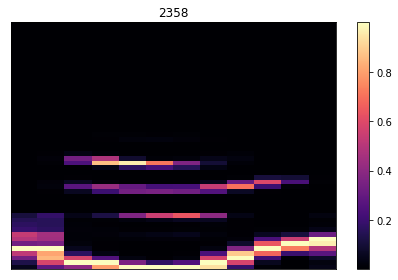

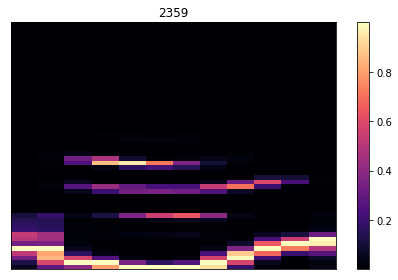

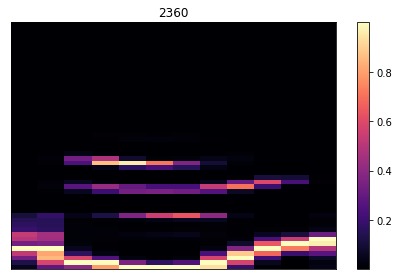

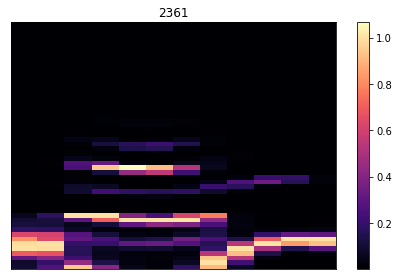

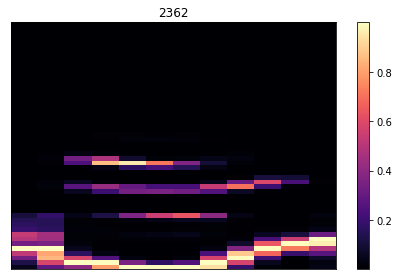

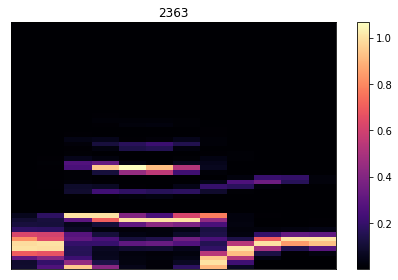

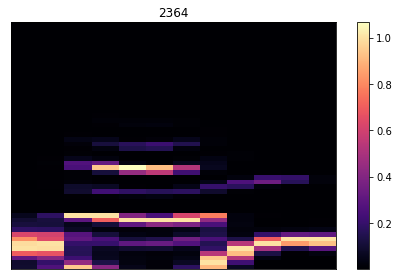

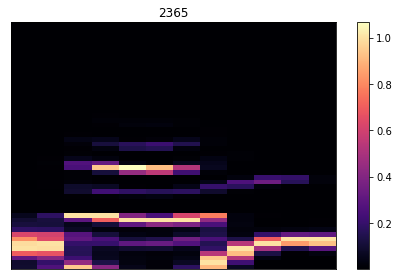

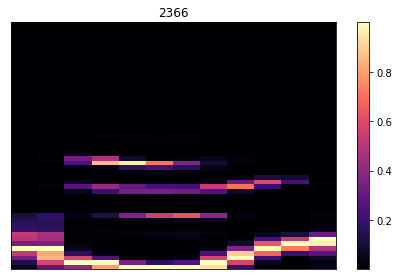

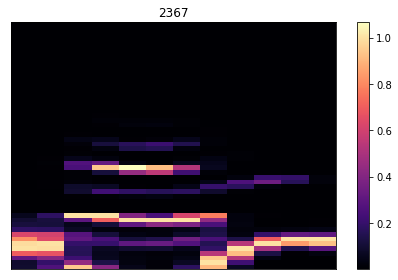

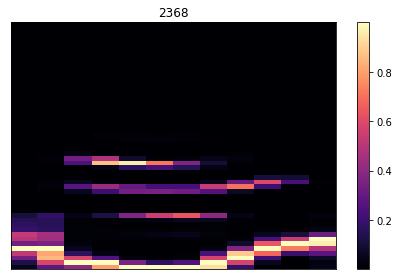

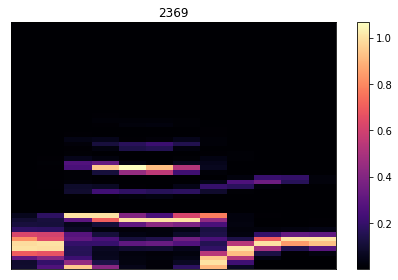

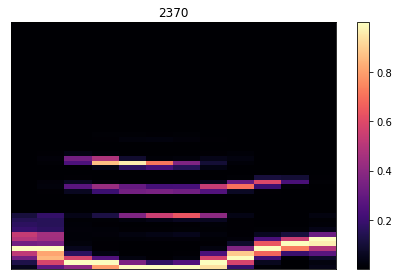

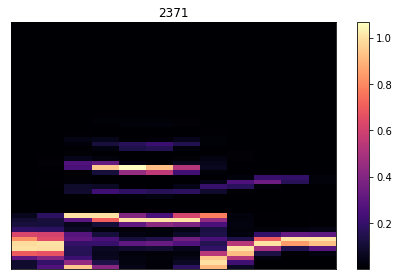

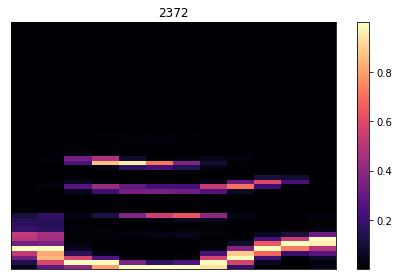

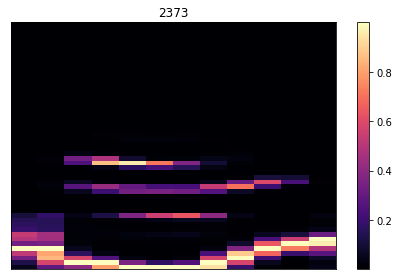

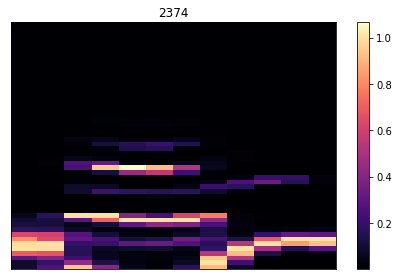

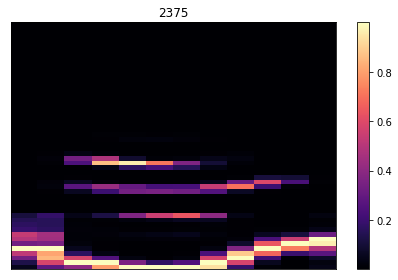

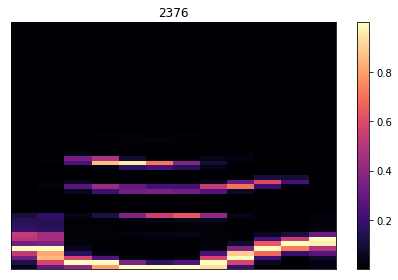

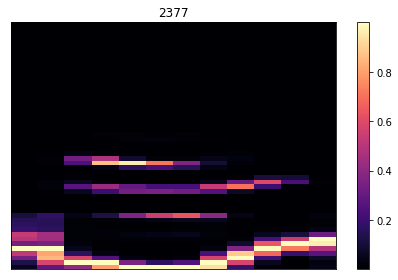

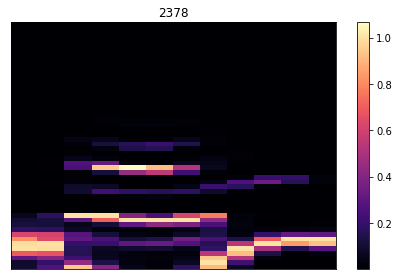

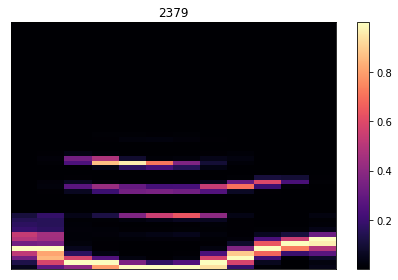

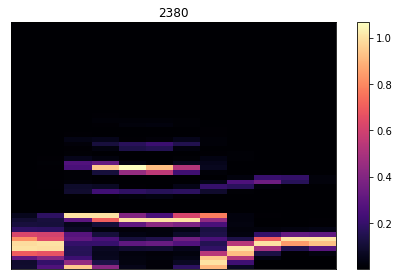

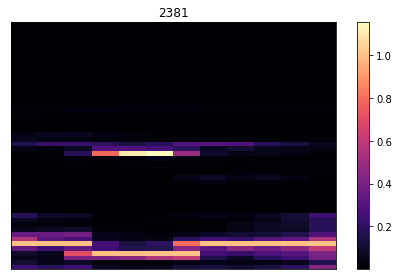

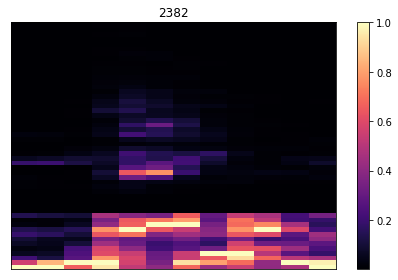

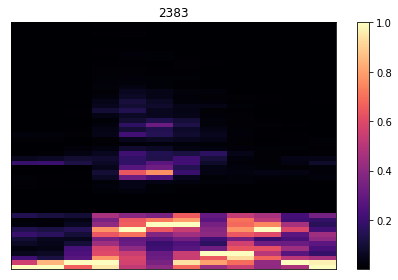

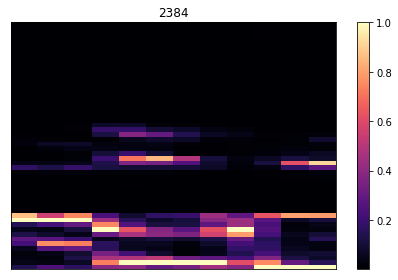

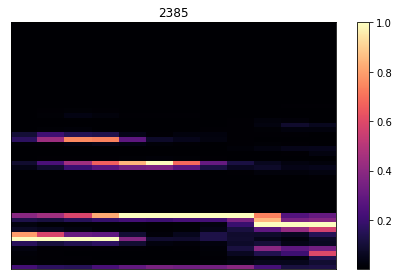

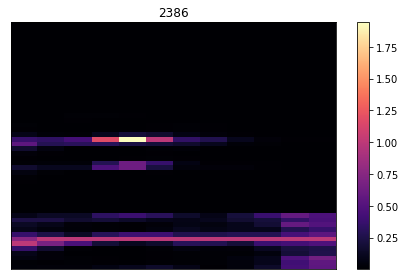

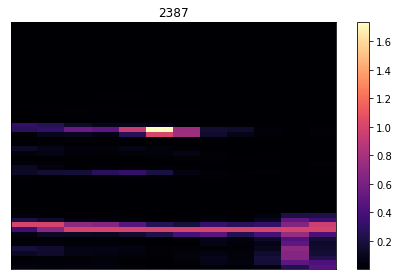

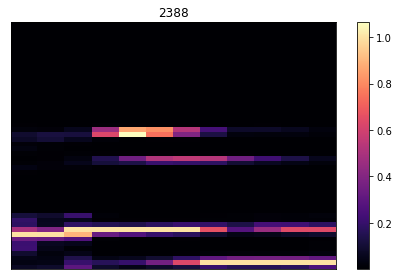

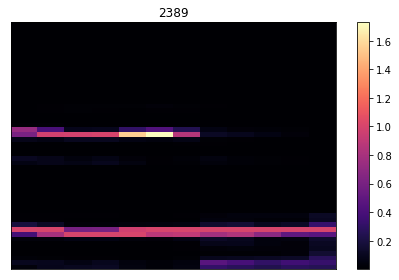

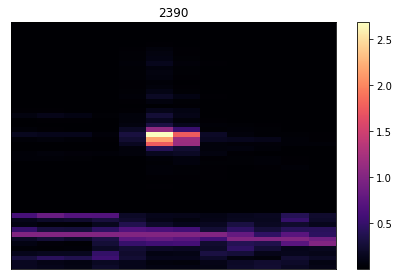

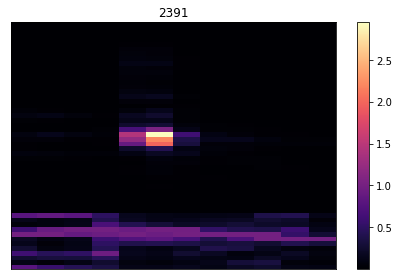

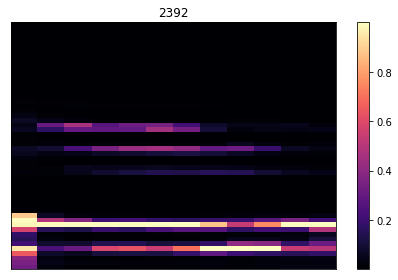

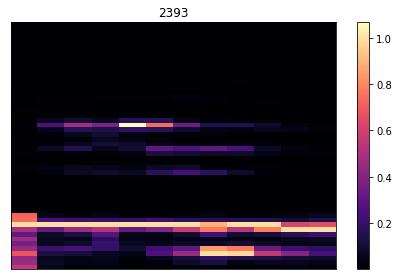

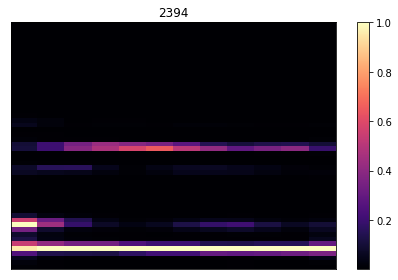

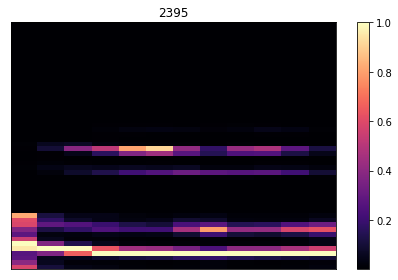

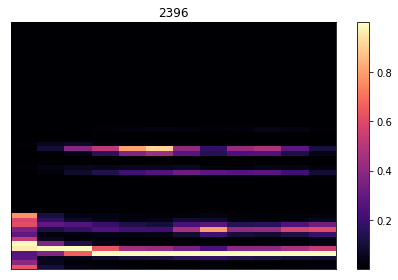

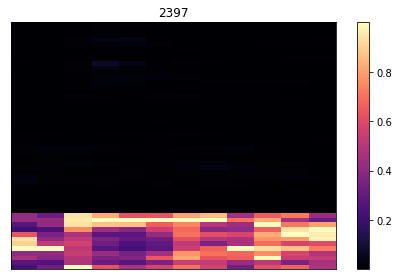

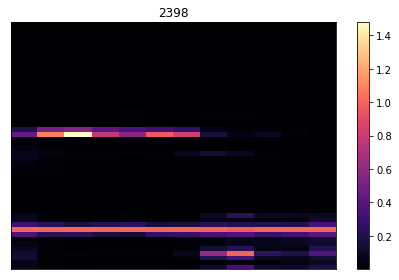

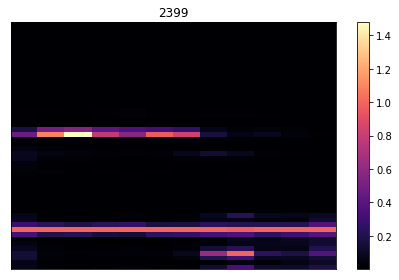

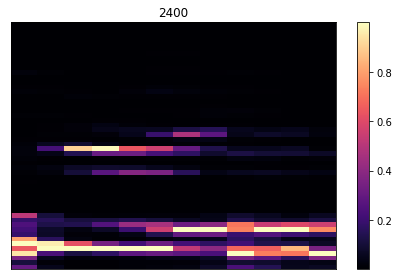

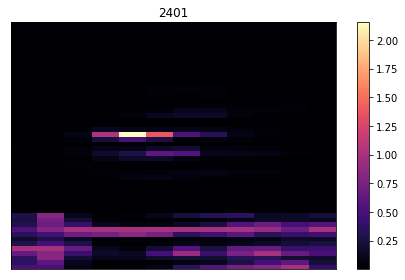

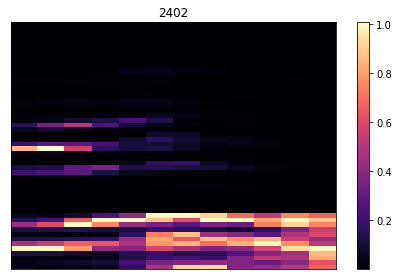

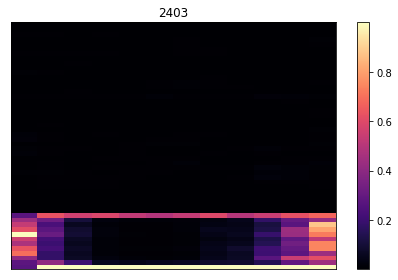

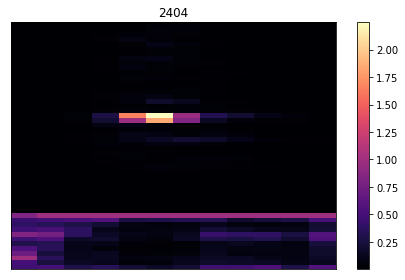

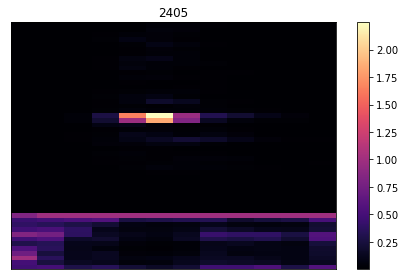

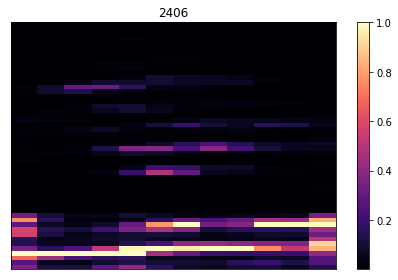

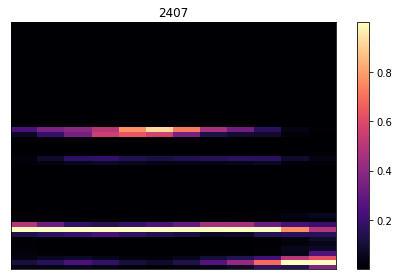

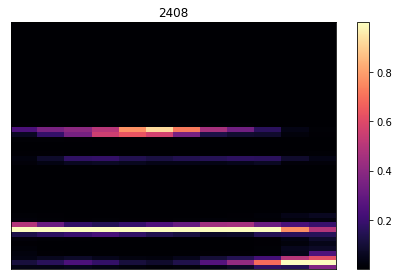

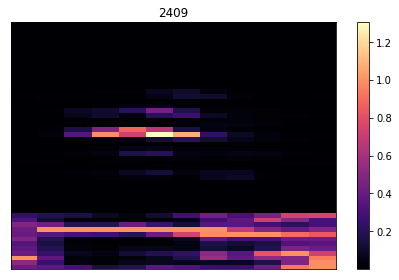

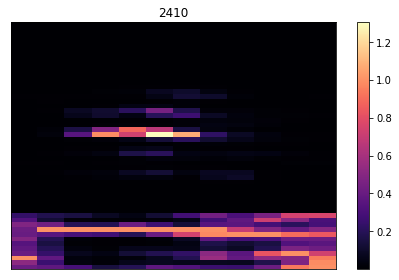

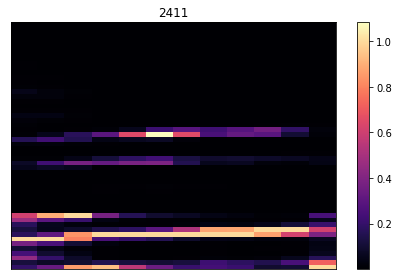

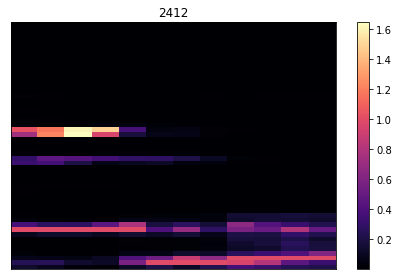

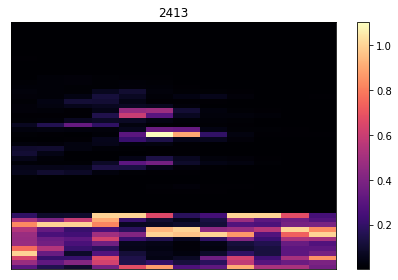

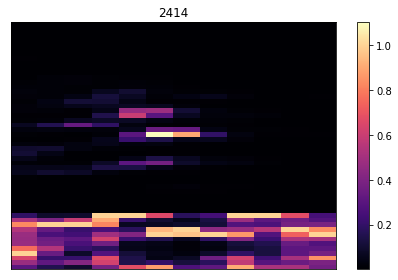

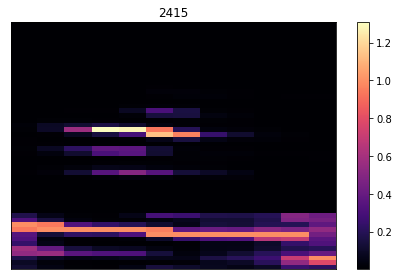

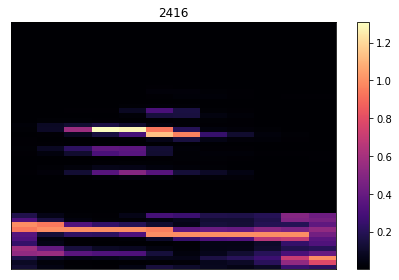

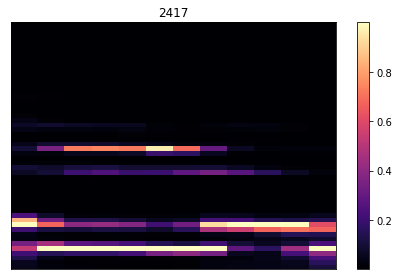

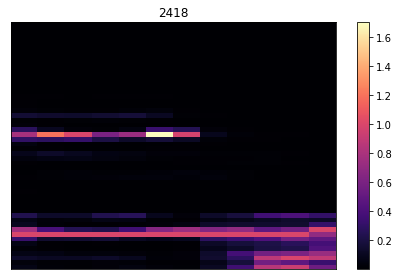

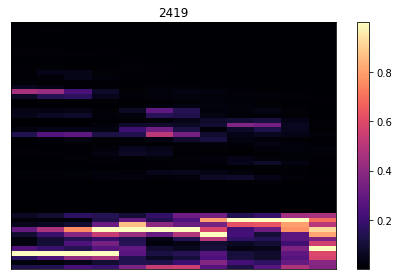

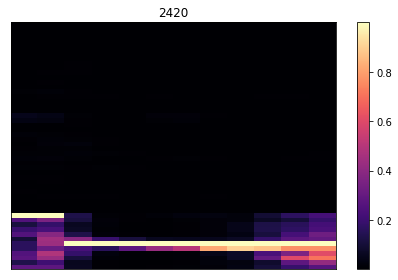

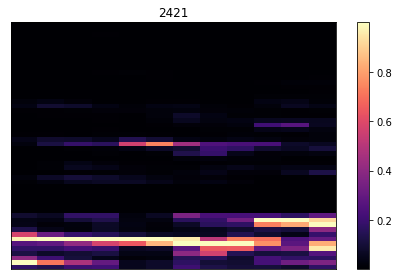

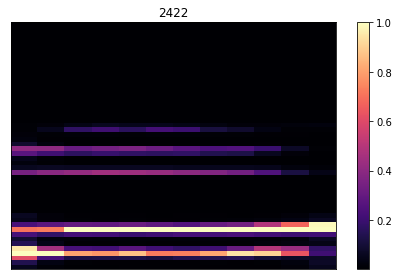

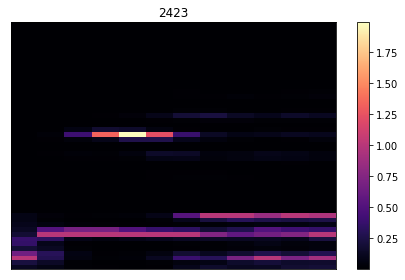

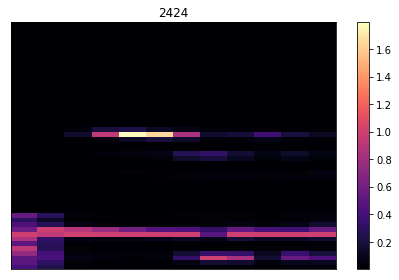

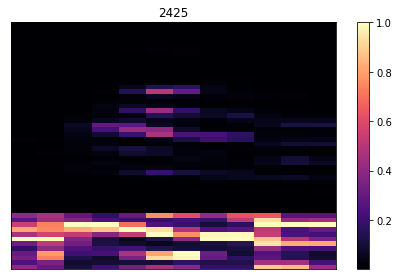

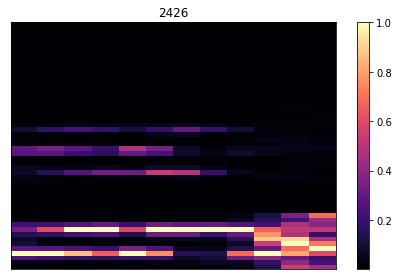

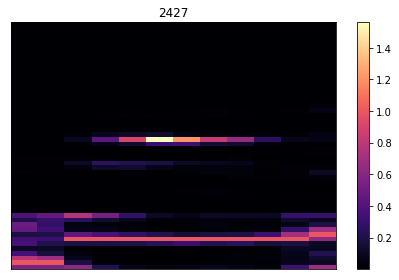

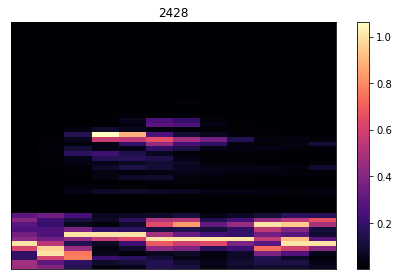

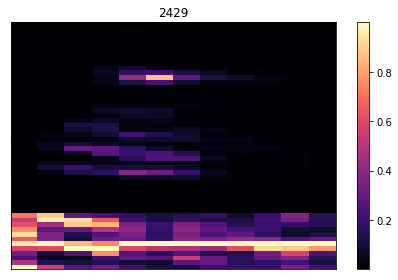

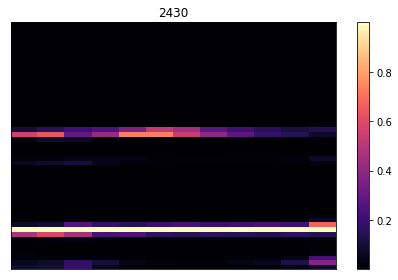

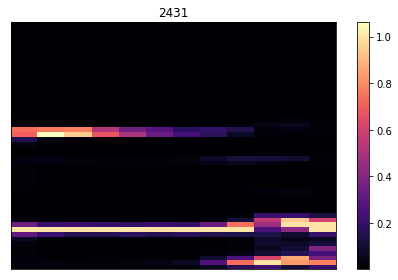

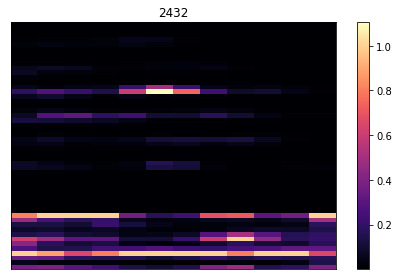

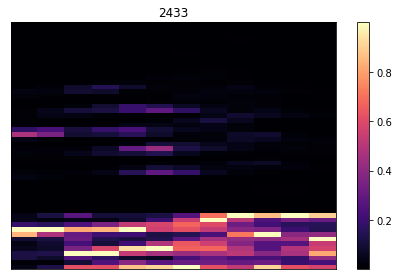

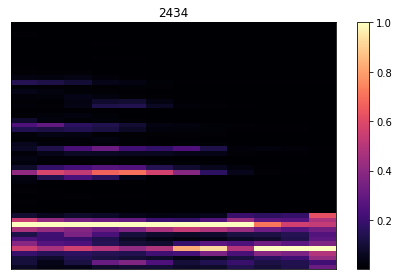

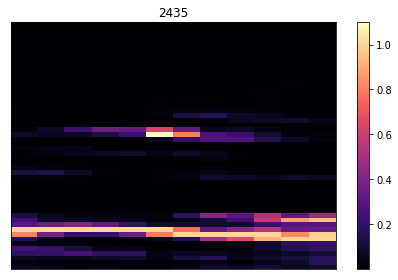

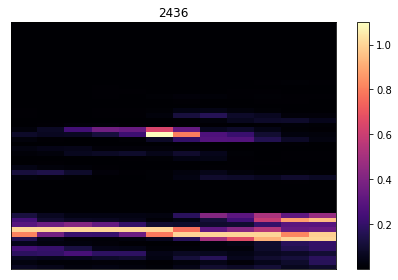

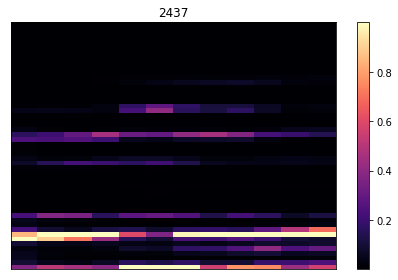

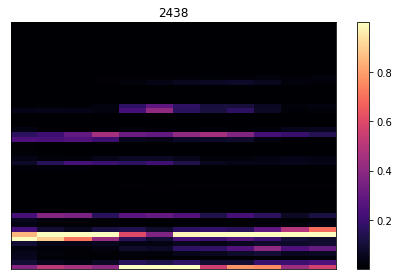

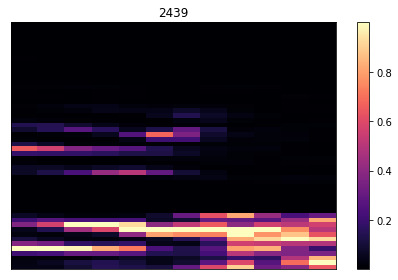

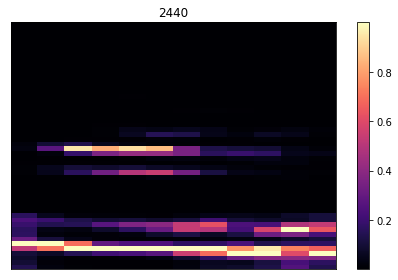

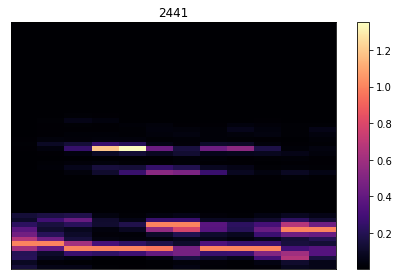

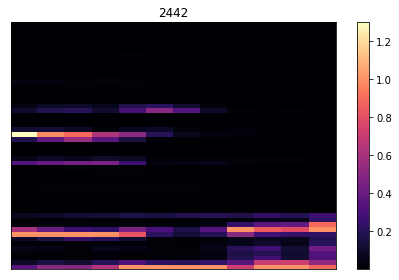

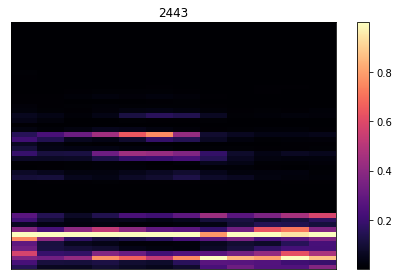

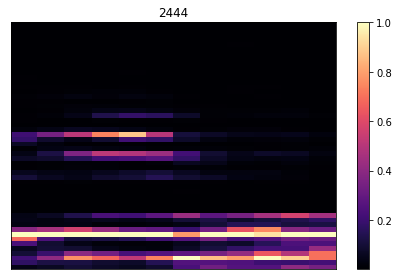

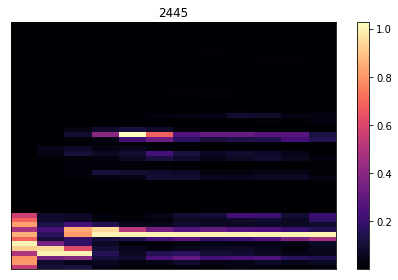

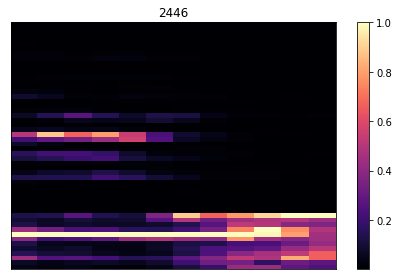

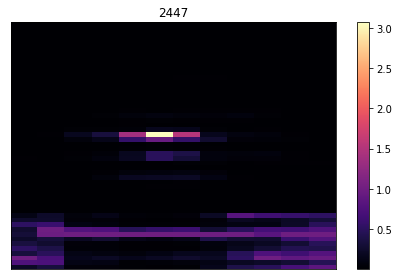

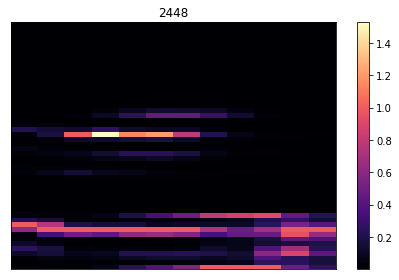

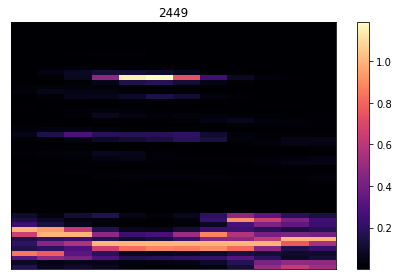

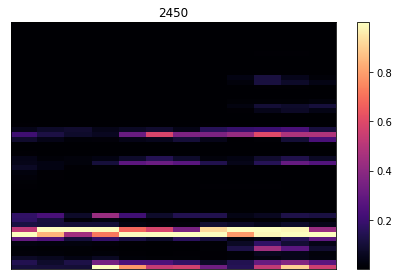

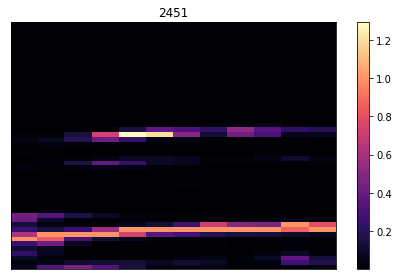

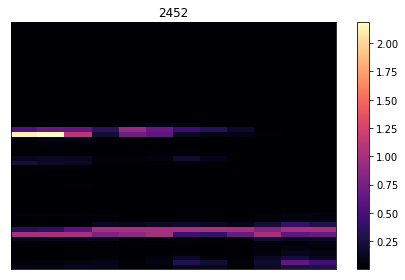

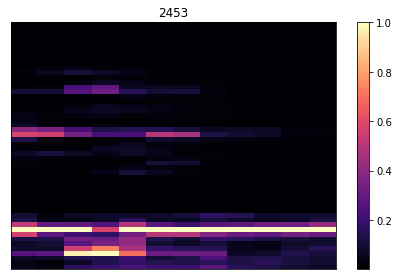

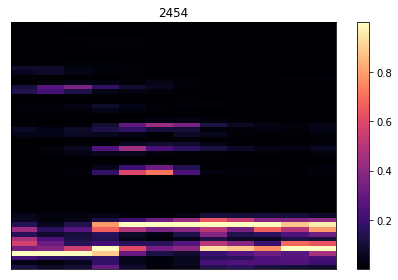

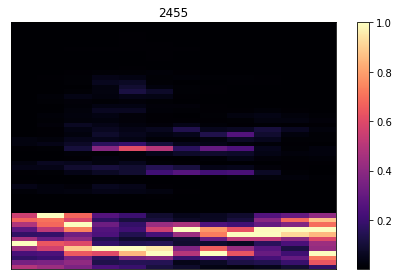

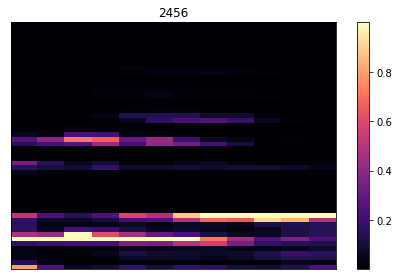

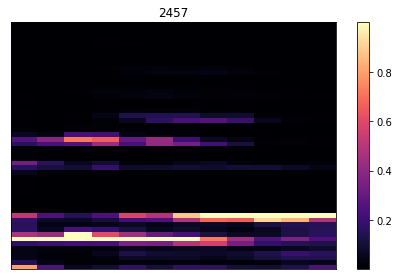

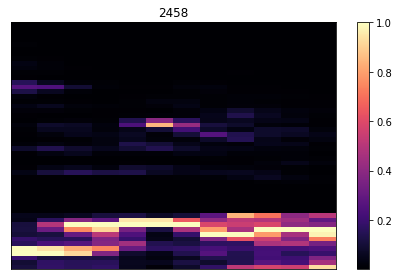

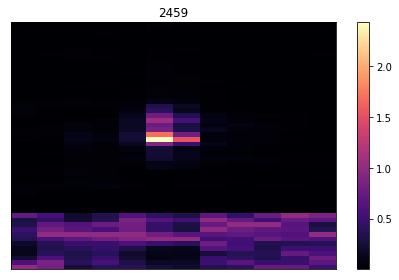

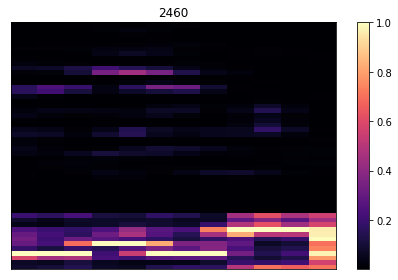

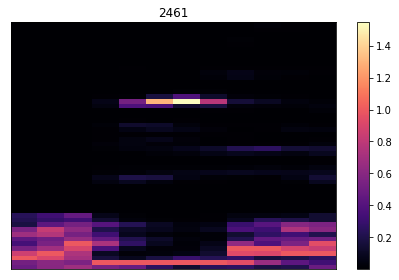

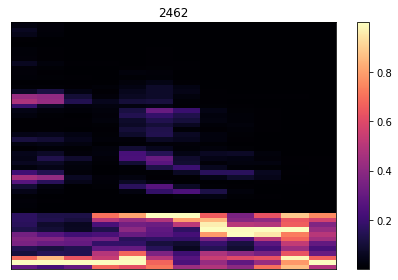

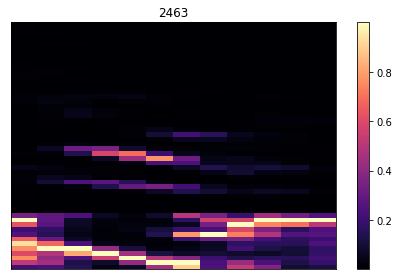

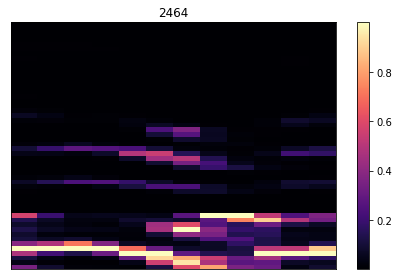

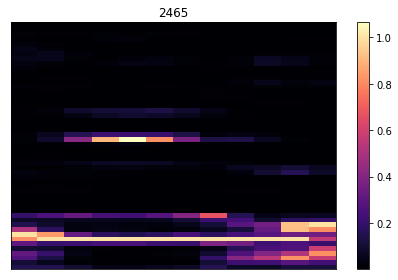

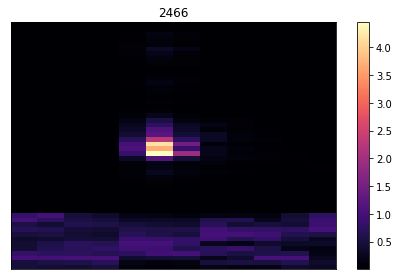

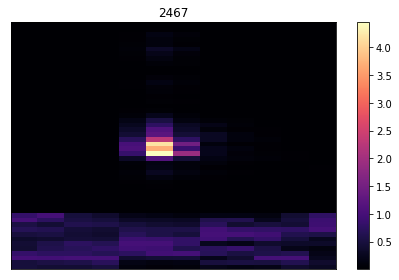

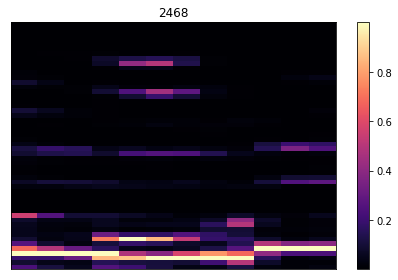

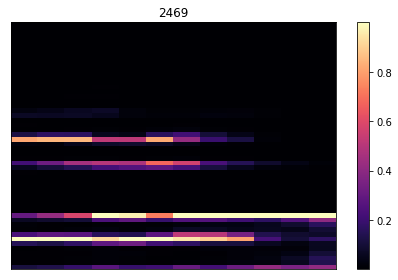

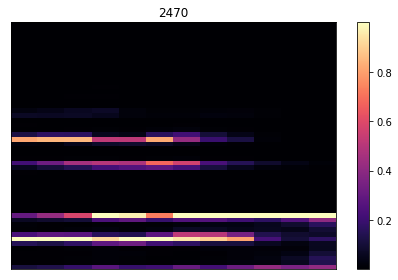

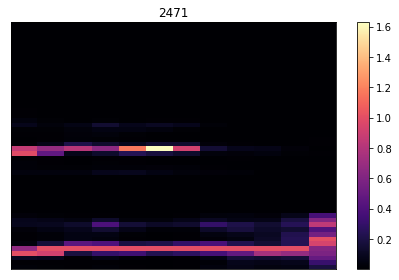

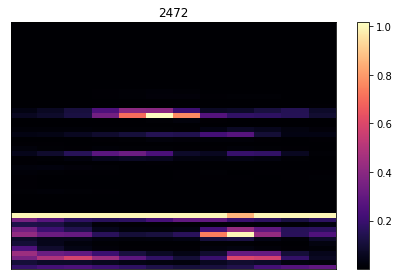

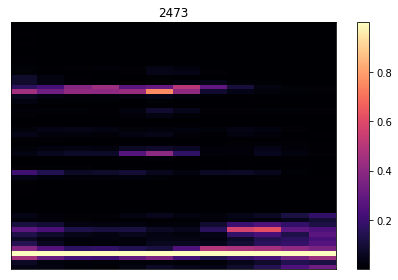

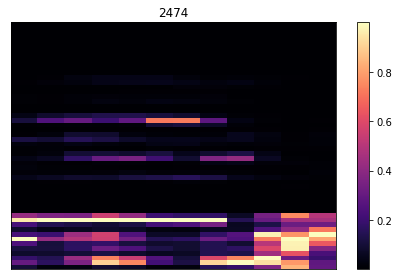

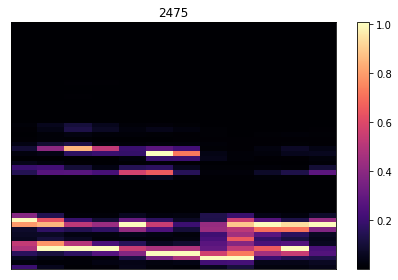

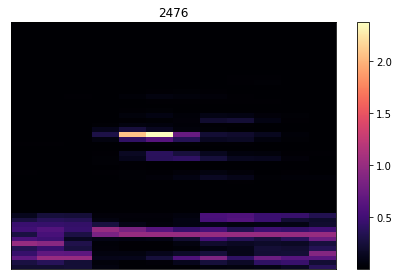

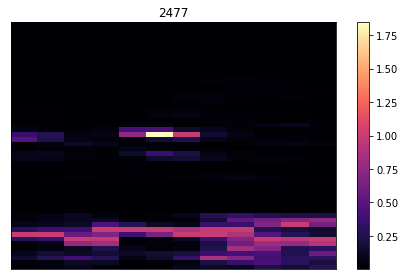

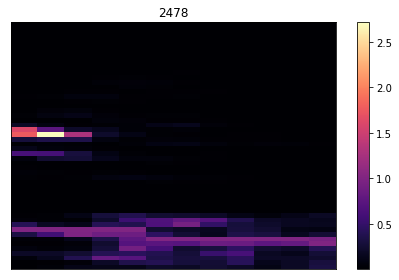

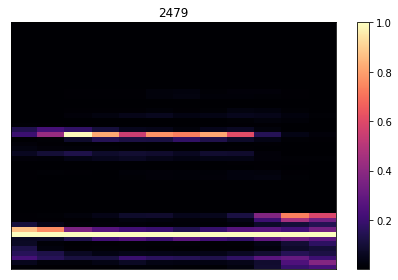

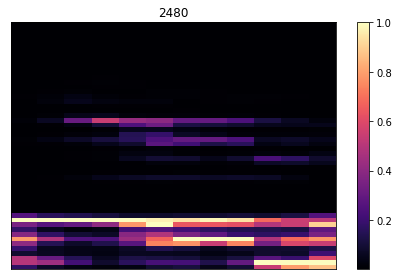

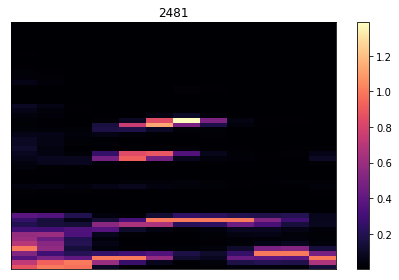

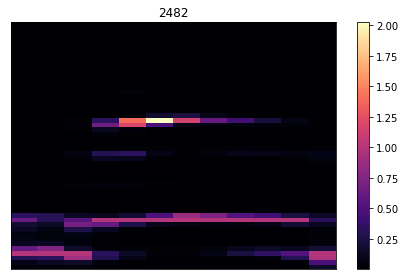

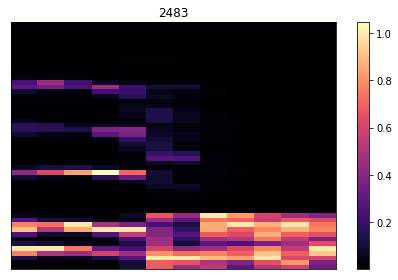

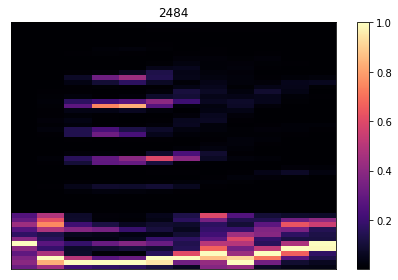

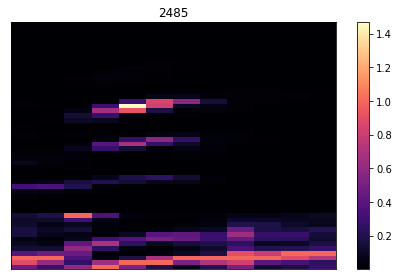

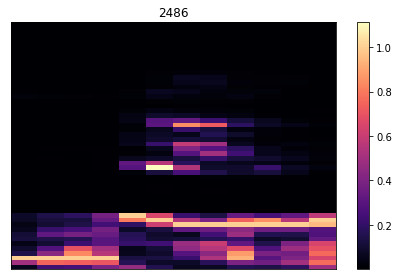

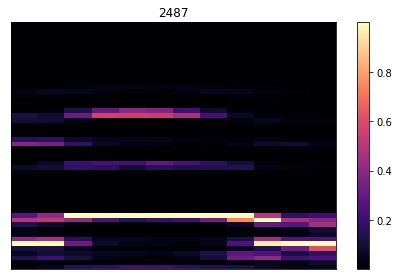

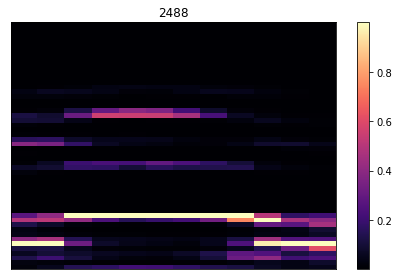

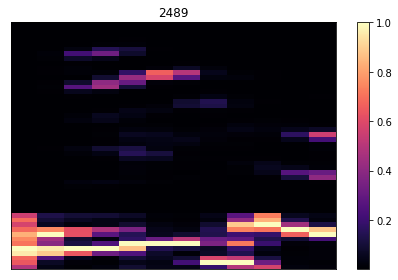

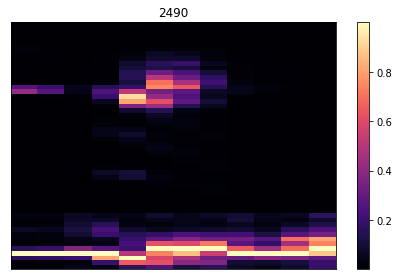

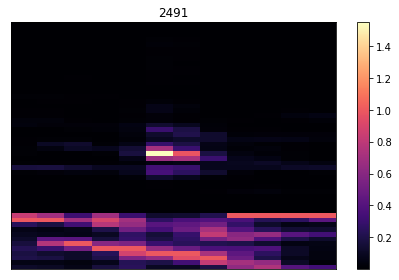

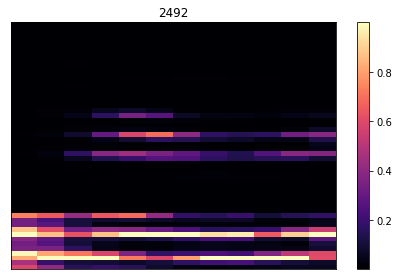

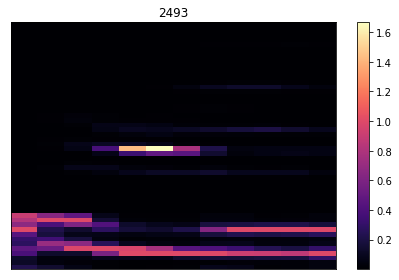

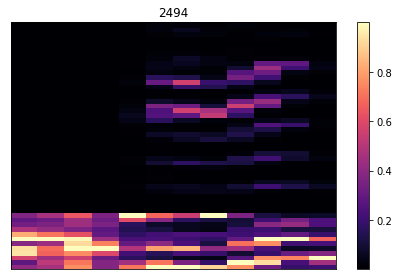

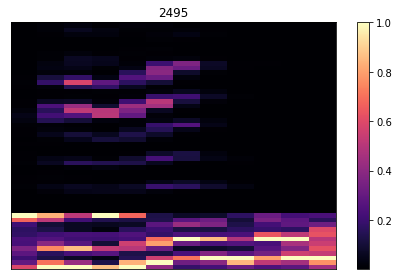

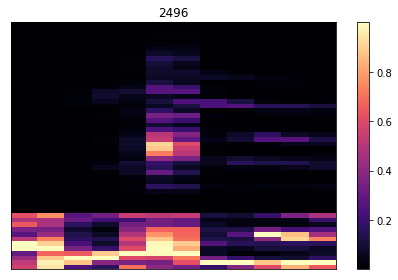

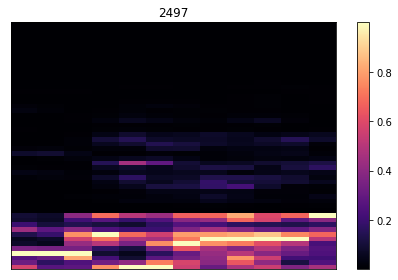

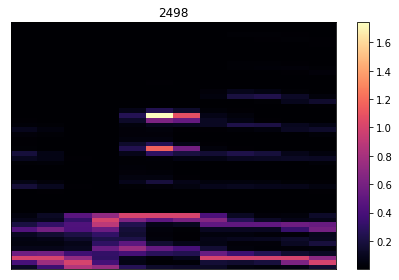

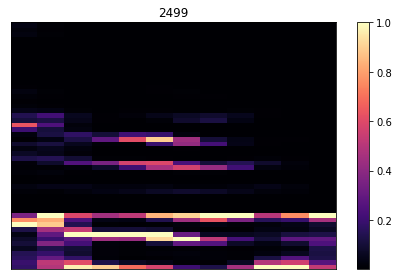

In [68]:
for i in range(2300,2500):
    plt.figure(figsize=(6, 4))
    # librosa.display.specshow(librosa.feature.chroma_stft(y=all_wave[26], sr=16000)[:40])#, y_axis='chroma', x_axis='time')
    librosa.display.specshow(all_feature[i])
    plt.colorbar()
    plt.title(i)
    plt.tight_layout()
    plt.show()

In [69]:
word = all_wave[1501]
norm = np.mean(abs(word))
normal_word = word/norm
ipd.Audio(normal_word, rate=16000)

In [42]:
norm

0.009167971

In [11]:
#data preprocessing
# labels=os.listdir(train_audio_path)
from sklearn.preprocessing import LabelEncoder
all_feature = np.array(all_feature)
feature_vector = all_feature[0]
print(all_feature.shape)
feature_size = feature_vector.shape

le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))
# all_feature = np.array(all_feature).reshape(-1,feature_size[0],feature_size[1],1)
all_feature2 = np.array(all_feature).reshape(-1,feature_size[0],feature_size[1],1)
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_feature2),np.array(y),stratify=y,test_size = 0.3,random_state=677,shuffle=True)

(2867, 52, 12)


In [5]:
#thiết kế mô hình deep learning 2D
from keras.models import Model, Sequential
from keras.layers import *
from keras.activations import *
from keras.optimizers import Adam,RMSprop,SGD
model = Sequential()
# model1.add(Conv1D(8, kernel_size=15, strides=1, padding='valid',
#                   input_shape=(feature_size[0],1)))
model.add(Conv2D(16, (7, 7), padding='same',
                 input_shape=(feature_size[0],feature_size[1],1)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv2D(32, (5, 5), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(24))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(11, activation='softmax'))

# adam = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 52, 12, 16)        800       
_________________________________________________________________
activation_1 (Activation)    (None, 52, 12, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 52, 12, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 12, 32)        12832     
_________________________________________________________________
activation_2 (Activation)    (None, 52, 12, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 6, 32)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 26, 6, 32)        

In [6]:
# learning rate schedule
def lr_schedule(epoch):
#     return 0.001
    if epoch < 5:
        return 0.016
    elif epoch < 10:
        return 0.008
    elif epoch < 20:
        return 0.004
    elif epoch < 40:
        return 0.002
    else:
        return 0.001
callbacks = [LearningRateScheduler(schedule=lr_schedule, verbose=1),
            ModelCheckpoint(os.path.join("./", "model.h5"),
            monitor='val_loss', verbose=1, save_best_only=True)]

In [9]:
# learning rate schedule
def lr_schedule(epoch):
    return 0.001
callbacks = [LearningRateScheduler(schedule=lr_schedule, verbose=1),
            ModelCheckpoint(os.path.join("./", "model.h5"),
            monitor='val_loss', verbose=1, save_best_only=True)]

In [12]:
#luyện mô hình 
classifier = model.fit(x_tr,
                    y_tr,validation_data=( x_val, y_val),
                    callbacks=callbacks,
                    validation_steps = 1,
                    steps_per_epoch = 5,
                    epochs=200,
                    batch_size=None)

Train on 2006 samples, validate on 861 samples
Epoch 1/200

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
5/5 [==============================] - 10s 2s/step - loss: 0.1676 - accuracy: 0.9457 - val_loss: 0.0676 - val_accuracy: 0.9861

Epoch 00001: val_loss improved from 0.13051 to 0.06755, saving model to ./model.h5
Epoch 2/200

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
5/5 [==============================] - 10s 2s/step - loss: 0.1645 - accuracy: 0.9501 - val_loss: 0.0652 - val_accuracy: 0.9849

Epoch 00002: val_loss improved from 0.06755 to 0.06517, saving model to ./model.h5
Epoch 3/200

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
5/5 [==============================] - 10s 2s/step - loss: 0.1574 - accuracy: 0.9502 - val_loss: 0.0610 - val_accuracy: 0.9895

Epoch 00003: val_loss improved from 0.06517 to 0.06104, saving model to ./model.h5
Epoch 4/200

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.


5/5 [==============================] - 13s 3s/step - loss: 0.1172 - accuracy: 0.9593 - val_loss: 0.0540 - val_accuracy: 0.9884

Epoch 00031: val_loss did not improve from 0.05229
Epoch 32/200

Epoch 00032: LearningRateScheduler setting learning rate to 0.001.
5/5 [==============================] - 12s 2s/step - loss: 0.1118 - accuracy: 0.9621 - val_loss: 0.0518 - val_accuracy: 0.9884

Epoch 00032: val_loss improved from 0.05229 to 0.05185, saving model to ./model.h5
Epoch 33/200

Epoch 00033: LearningRateScheduler setting learning rate to 0.001.
5/5 [==============================] - 12s 2s/step - loss: 0.1097 - accuracy: 0.9639 - val_loss: 0.0517 - val_accuracy: 0.9884

Epoch 00033: val_loss improved from 0.05185 to 0.05169, saving model to ./model.h5
Epoch 34/200

Epoch 00034: LearningRateScheduler setting learning rate to 0.001.
5/5 [==============================] - 12s 2s/step - loss: 0.1181 - accuracy: 0.9591 - val_loss: 0.0531 - val_accuracy: 0.9884

Epoch 00034: val_loss did no

5/5 [==============================] - 12s 2s/step - loss: 0.0939 - accuracy: 0.9663 - val_loss: 0.0525 - val_accuracy: 0.9884

Epoch 00062: val_loss did not improve from 0.05023
Epoch 63/200

Epoch 00063: LearningRateScheduler setting learning rate to 0.001.
5/5 [==============================] - 12s 2s/step - loss: 0.1033 - accuracy: 0.9643 - val_loss: 0.0524 - val_accuracy: 0.9872

Epoch 00063: val_loss did not improve from 0.05023
Epoch 64/200

Epoch 00064: LearningRateScheduler setting learning rate to 0.001.
5/5 [==============================] - 12s 2s/step - loss: 0.1015 - accuracy: 0.9658 - val_loss: 0.0483 - val_accuracy: 0.9907

Epoch 00064: val_loss improved from 0.05023 to 0.04831, saving model to ./model.h5
Epoch 65/200

Epoch 00065: LearningRateScheduler setting learning rate to 0.001.
5/5 [==============================] - 12s 2s/step - loss: 0.0948 - accuracy: 0.9682 - val_loss: 0.0510 - val_accuracy: 0.9884

Epoch 00065: val_loss did not improve from 0.04831
Epoch 66/

5/5 [==============================] - 12s 2s/step - loss: 0.0812 - accuracy: 0.9716 - val_loss: 0.0504 - val_accuracy: 0.9884

Epoch 00093: val_loss did not improve from 0.04606
Epoch 94/200

Epoch 00094: LearningRateScheduler setting learning rate to 0.001.
5/5 [==============================] - 12s 2s/step - loss: 0.0797 - accuracy: 0.9722 - val_loss: 0.0531 - val_accuracy: 0.9872

Epoch 00094: val_loss did not improve from 0.04606
Epoch 95/200

Epoch 00095: LearningRateScheduler setting learning rate to 0.001.
5/5 [==============================] - 13s 3s/step - loss: 0.0782 - accuracy: 0.9720 - val_loss: 0.0530 - val_accuracy: 0.9884

Epoch 00095: val_loss did not improve from 0.04606
Epoch 96/200

Epoch 00096: LearningRateScheduler setting learning rate to 0.001.
5/5 [==============================] - 12s 2s/step - loss: 0.0724 - accuracy: 0.9749 - val_loss: 0.0508 - val_accuracy: 0.9884

Epoch 00096: val_loss did not improve from 0.04606
Epoch 97/200

Epoch 00097: LearningRateSc


Epoch 00124: val_loss did not improve from 0.04606
Epoch 125/200

Epoch 00125: LearningRateScheduler setting learning rate to 0.001.
5/5 [==============================] - 13s 3s/step - loss: 0.0743 - accuracy: 0.9720 - val_loss: 0.0538 - val_accuracy: 0.9872

Epoch 00125: val_loss did not improve from 0.04606
Epoch 126/200

Epoch 00126: LearningRateScheduler setting learning rate to 0.001.
4/5 [=======================>......] - ETA: 2s - loss: 0.0677 - accuracy: 0.9762

KeyboardInterrupt: 

In [13]:
# lưu kiến trúc của model đã luyện vào file json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# lưu các trọng số của model
# model.save_weights("model.h5")
print("Saved model architecture to disk")
# model.summary()

Saved model architecture to disk


In [98]:
print("* init")
import os
import IPython.display as ipd
# from scipy.io import wavfile #để đọc file wav 
# import warnings
import tensorflow as tf
# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import socket
import pyaudio
import wave
import struct
import numpy as np
CHUNK = 16000 # read each 1000 miliseconds
FORMAT = pyaudio.paFloat32
CHANNELS = 1
RATE = 16000
RECORD_SECONDS = 20
WORD = 6000
WORD_HALF = int(WORD/2)
WORD_QUAD = int(WORD/2)
# circular_buf_size = 50
p = pyaudio.PyAudio()
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model.h5")
model.summary()
# open the file for reading.
wf = wave.open("test.wav", 'rb')
# open stream based on the wave object which has been input.
# stream = p.open(format =
#                 p.get_format_from_width(wf.getsampwidth()),
#                 channels = wf.getnchannels(),
#                 rate = wf.getframerate(),
#                 input = True)
stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)
# stream = p.open("test.wav",format=FORMAT,
#                 channels=CHANNELS,)
frames = []
features = []
waves = []
words = []
circular_index = 0
os.system( 'cls' )
print("* recording")
inputDataNew = np.ndarray(shape=(CHUNK), dtype=float)
inputDataOld = np.ndarray(shape=(WORD_QUAD), dtype=float)
last_word_time = 0
i=0
while 1:
    data = stream.read(CHUNK) 
    #convert to float array
    for j in range(0, int(len(data)/4)):
        value = struct.unpack('f', data[j*4:j*4+4])
        inputDataNew[j] = value[0]
    #megre end of old and new
    inputData = np.concatenate((inputDataOld,inputDataNew))
    inputDataOld = inputDataNew[CHUNK-WORD_QUAD:].copy()
    i=i+1
    if i<2:
        continue
    else:
        
        energy = abs(inputData)
        mean = np.mean(energy)
        value = 0
        max_val = 0
        max_idn = 0
        for idn in range(0,len(energy)):
            value += (energy[idn]-value)/300
            if (idn>WORD_HALF) & (idn<(len(inputData)-WORD_HALF )):
                if max_val<value:
                    max_val = value
                    max_idn = idn
        if max_val>(mean*2):
            global_time = i*CHUNK+max_idn-WORD_QUAD
            if (global_time-last_word_time)< WORD:
                continue
            last_word_time = global_time
            data = inputData[max_idn-WORD_HALF:max_idn+WORD_HALF]
            norm = np.mean(abs(data))*250
            data = data/norm
            feature_vector_1 = librosa.feature.chroma_stft(y=data, sr=16000)
            feature_vector_2 = librosa.feature.melspectrogram(y=data, sr=16000)[:40]
            feature_vector = np.concatenate((feature_vector_1,feature_vector_2))
            modelInput = np.array(feature_vector).reshape(1,feature_vector.shape[0],feature_vector.shape[1],1)
            output = model.predict(modelInput)
            indexMax = np.argmax(output[0], axis=0) 
            confident = output[0][indexMax]
            if ((indexMax!=10)&(confident>0.8)):
#             os.system( 'cls' )
                print ("ID:",len(waves)," prediction:",indexMax,"confident:",output[0][indexMax]," time:",global_time/RATE)
                waves.append(inputData)
                words.append(data)
                features.append(feature_vector)
                byte_message = (indexMax)
                opened_socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
                opened_socket.sendto(byte_message, ("127.0.0.1", 5005))
#             plt.figure(figsize=(10, 4))
#             librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
#             plt.colorbar()
#             plt.title('Chromagram')
#             plt.tight_layout()
#             plt.show()
print("* done recording")    

* init
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 52, 12, 16)        800       
_________________________________________________________________
activation_1 (Activation)    (None, 52, 12, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 52, 12, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 12, 32)        12832     
_________________________________________________________________
activation_2 (Activation)    (None, 52, 12, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 6, 32)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 26, 6, 32) 

KeyboardInterrupt: 